## Import Packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import datetime
import random
from pprint import pprint
from tqdm import tqdm

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from ts.data.dataset import SeattleRainfall
from ts.utility import Utility
from ts.experimental import GeneralizedParetoDistribution, GpdEstimate, Pso
from ts.plot import Plot

## Load Dataset

In [2]:
rainfall_df = pd.read_csv('../datasets/rainfall-data.csv')[['YEAR', 'MN', 'DT', '..R/F']]
rainfall_df

,YEAR,MN,DT,..R/F
0,1970,1,1,0.0
1,1970,1,2,3.2
2,1970,1,3,0.0
3,1970,1,4,0.0
4,1970,1,5,0.0
...,...,...,...,...
17647,2018,4,26,0.0
17648,2018,4,27,2.1
17649,2018,4,28,0.0
17650,2018,4,29,0.0


### Get Rainfall Series

In [3]:
rainfall_series = rainfall_df['..R/F'].to_numpy()
n = rainfall_series.shape[0]

print(f'Rainfall data: datatype: {rainfall_series.dtype}, '
    + f'shape: {rainfall_series.shape}, '
    + f'Contains NaN: {np.isnan(rainfall_series).any()}')

Rainfall data: datatype: float64, shape: (17652,), Contains NaN: False


In [6]:
date_series = [0] * len(rainfall_df)

for index, row in rainfall_df.iterrows():
    date_series[index] = datetime.date(int(row['YEAR']), int(row['MN']), int(row['DT']))

## Train-Test Split

In [7]:
train_frac = 0.90
num_train = int(n * train_frac)

print(f'Length of training series: {num_train}, '
     + f'Length of test series: {n - num_train}')

Length of training series: 15886, Length of test series: 1766


### Plot Entire Data

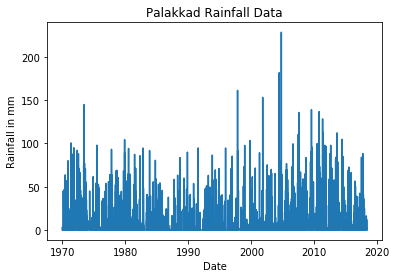

In [8]:
plt.plot(date_series, rainfall_df['..R/F'].to_numpy())
plt.title('Palakkad Rainfall Data')
plt.xlabel('Date')
plt.ylabel('Rainfall in mm')
plt.show()

### All Data Histogram

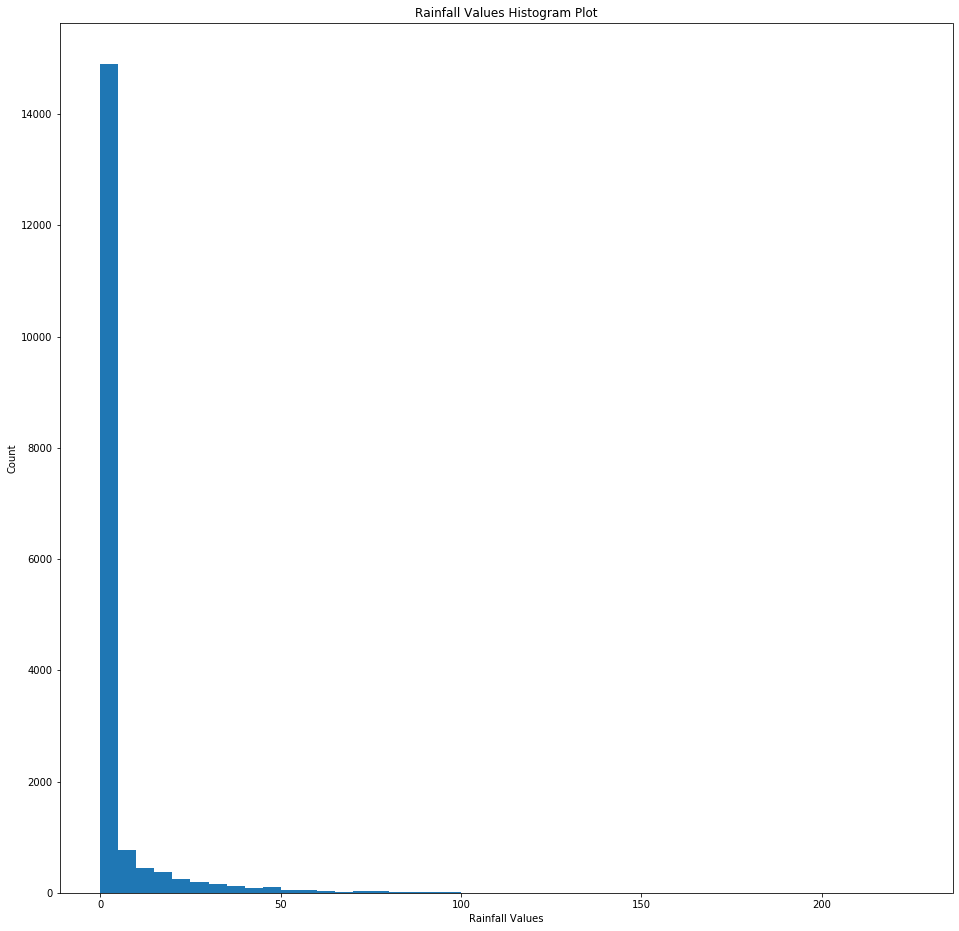

In [9]:
bin_width = 5
bins = np.arange(
    rainfall_series.min(), rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(16, 16))
plt.hist(rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Data histogram of values above a lower bound

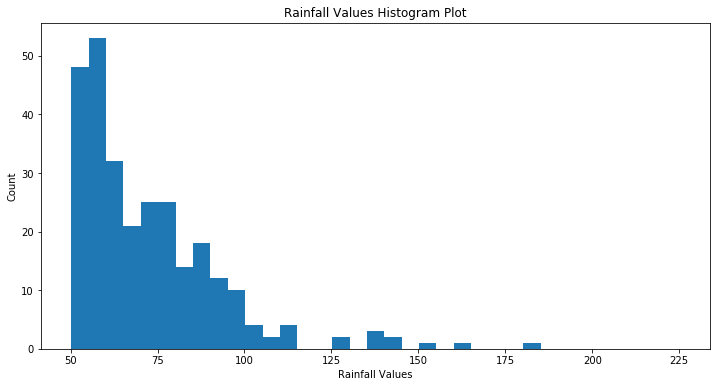

In [10]:
lower_bound = 50

bounded_rainfall_series = \
    rainfall_series[rainfall_series > lower_bound]

bin_width = 5
bins = np.arange(
    bounded_rainfall_series.min(), 
    bounded_rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(12, 6))
plt.hist(bounded_rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Complementary Cumulative Data of values above a lower bound

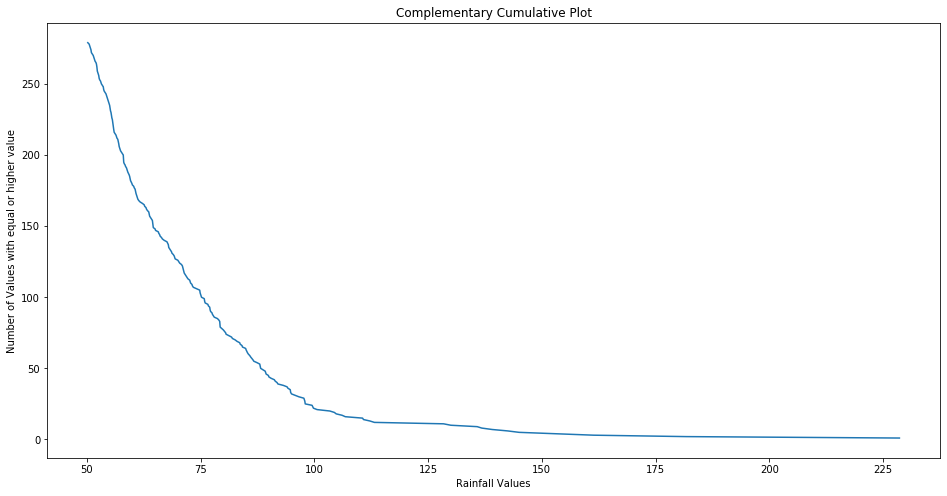

In [11]:
lower_bound = 50

bounded_count = dict()

for rain_value in rainfall_series:
    
    if rain_value <= lower_bound:
        continue
    
    if rain_value not in bounded_count:
        bounded_count[rain_value] = 1
    else:
        bounded_count[rain_value] += 1
        
rainfall_count = list(bounded_count.items())
rainfall_count.sort(key=lambda rain_count: rain_count[0])
rainfall_arr, count_arr = list(zip(*rainfall_count))
count_cusum_rev = [0] * len(count_arr)

count_cusum_rev[-1] = count_arr[-1]
for i in range(len(count_cusum_rev) - 2, -1, -1):
    count_cusum_rev[i] = count_cusum_rev[i + 1] + count_arr[i]

plt.figure(figsize=(16, 8))
plt.plot(rainfall_arr, count_cusum_rev)
plt.xlabel('Rainfall Values')
plt.ylabel('Number of Values with equal or higher value')
plt.title('Complementary Cumulative Plot')
plt.show()

## Computing Threshold Exceedances

In [12]:
threshold = 50 # Rainfall in mm

exceed_series = []

for i in range(num_train):
    
    if rainfall_series[i] > threshold:
        exceed_series.append(rainfall_series[i] - threshold)
        
exceed_series = np.array(exceed_series)

print(f'Exceedances Series: datatype: {exceed_series.dtype}, '
    + f'shape: {exceed_series.shape}')

Exceedances Series: datatype: float64, shape: (247,)


# Parameter Estimation of GEV fitted to Remainder Series

Shape Parameter: 0.0043730924920598845 
Scale Parameter: 23.345168127269034 
Log Likelihood: -1026.2264947033077


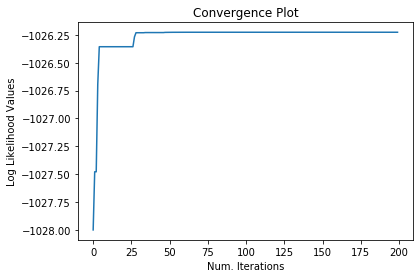

In [13]:
params, max_log_likelihood, max_log_likelihood_vals = GpdEstimate.psoMethod(
    exceed_series,
    Pso.computeInitialPos([(-10, 10), (5, 30)], 250),
    numIterations=200
)

shape, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [14]:
gpd_dist = GeneralizedParetoDistribution(*tuple(params))

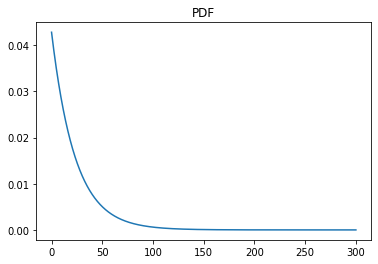

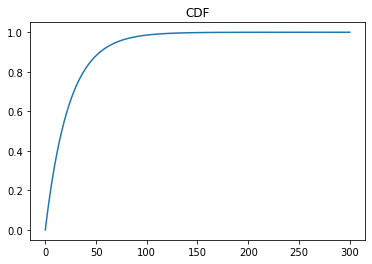

In [15]:
x = np.linspace(0, 300, 10000)

plt.plot(x, gpd_dist.pdf(x))
plt.title('PDF')
plt.show()

plt.plot(x, gpd_dist.cdf(x))
plt.title('CDF')
plt.show()

# Algorithm

## Part 1: Extreme Value CDF Prediction Algorithm

### Build Model Architecture

In [16]:
lag = 50

model_extreme = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model_extreme.build(input_shape=(None, lag))
model_extreme.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.02, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Build Training Data

In [17]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (247, 50)
Output Data: datatype: float64, shape: (247, 1)


In [18]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  0. ,  0. ,  0. , 47. ,  5. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        18. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  2.6,  1.6,  3. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  1.6,  0. , 10.6,  0. ,  0. , 25.2,
         0. ,  0. , 16.6,  5. , 14. , 14.2,  8.8,  2.6, 13. ,  1.2,  0. ,
         0. , 22.6, 33.6,  8.6, 18.6, 32.6],
       [ 0. ,  0. ,  3. ,  5.2, 11. ,  5. ,  2. ,  0. ,  0.8, 39. , 31.4,
        30.4, 15.2, 21. ,  2.8,  2. ,  0. ,  7.6,  6.2, 31. ,  9. , 19. ,
        12.8, 17. ,  0. ,  0. ,  2. , 20. ,  5. ,  2.6, 36. ,  1. , 25. ,
        16. ,  7. , 15. , 10. , 26. , 20. , 25.2, 12.2, 41.6,  6. ,  2. ,
         0. , 40. ,  0. , 38.8, 19. ,  9.6],
       [ 0. ,  3. ,  5.2, 11. ,  5. ,  2. ,  0. ,  0.8, 39. , 31.4, 30.4,
        15.2, 21. ,  2.8,  2. ,  0. ,  7.6,  6.2, 31. ,  9. , 19. , 12.8,
        17. ,  0. ,  0. ,  2. , 20. ,  5. ,  2.6, 36. ,  1. , 25. , 16. ,
         7. , 15. , 10. , 26. , 20. , 25.2, 12.2, 41.6,  6. ,  2. ,  0. ,
    

### Train the Model

Epoch 1/100
8/8 [==============================] - 0s 927us/step - loss: 0.1472
Epoch 2/100
8/8 [==============================] - 0s 952us/step - loss: 0.0994
Epoch 3/100
8/8 [==============================] - 0s 913us/step - loss: 0.0908
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0747
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0710
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0675
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0589
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0534
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0507
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0477
Epoch 11/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0433
Epoch 12/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0385
Epoch 13/100
8/8 [==============================] - 0s 

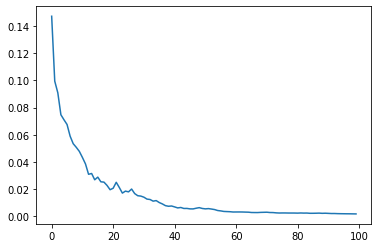

In [19]:
history = model_extreme.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Compute Test Loss

In [20]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))
        
        output_actual.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)
output_actual = np.expand_dims(np.array(output_actual), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)
pred_actual = threshold + gpd_dist.computeQuantile(pred_val)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss (CDF): {test_loss_cdf}')

test_loss = MeanSquaredError()(output_actual, pred_actual)
print(f'Test Loss (Actual): {test_loss}')

Input Test Data: datatype: float64, shape: (32, 50)
Output Test Data: datatype: float64, shape: (32, 1)

Test Loss (CDF): 0.10563148558139801
Test Loss (Actual): 488.73004150390625


## Part 2: Extreme Value Detection (Classification) Algorithm

In [21]:
class MlpEnsemble:
    
    def get_model(self, lag):
        
        model = Sequential([
            Dense(16, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])
        
        model.build(input_shape=(None, lag))
        model.compile(
            optimizer=Adam(
                ExponentialDecay(
                    1e-3, 50, 0.9
                )
            ),
            loss=BinaryCrossentropy(from_logits=True)
        )
        
        return model
    
    def __init__(self, lag, num_models=10, neg_data_ratio=1.0):
        
        self.models = [self.get_model(lag) for _ in range(num_models)]
        self.neg_data_ratio = neg_data_ratio
        
    def train(self, input_data, output_data, each_model_epochs):
        
        pos_data = []
        neg_data = []
        
        for i in range(input_data.shape[0]):
            
            if output_data[i, 0] == 1:
                pos_data.append((input_data[i], output_data[i]))
                
            else:
                neg_data.append((input_data[i], output_data[i]))
        
        assert len(pos_data) < len(neg_data)
        
        losses = np.zeros(each_model_epochs)
        num_neg_to_take = int(len(pos_data) * self.neg_data_ratio)
        
        for model in self.models:
            
            data = pos_data.copy()
            data.extend(random.sample(neg_data, k=num_neg_to_take))
            
            input_data, output_data = [], []
            for inp, out in data:
                input_data.append(inp)
                output_data.append(out)
                
            input_data = np.array(input_data)
            output_data = np.array(output_data)
        
            history = model.fit(
                input_data, 
                output_data, 
                epochs=each_model_epochs,
                verbose=0
            )
            
            losses += np.array(history.history['loss'])
                
        losses /= len(self.models)
        return losses
    
    def predict(self, input_data):
        
        num_pos = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        num_neg = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        
        for model in self.models:
            
            model_out = model.predict(input_data)
            model_pred = (tf.sigmoid(model_out).numpy() > 0.5) \
                .astype(np.int64)
            
            num_pos += model_pred
            num_neg += (1 - model_pred)
            
        pred = (num_pos > num_neg).astype(np.int64)
        return pred

In [22]:
model_detect = MlpEnsemble(lag=lag, num_models=10, neg_data_ratio=1.5)

### Build Training Data

In [23]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    input_data.append(rainfall_series[i - lag: i])
    
    if rainfall_series[i] > threshold:
        output_data.append(1)
    
    else:
        output_data.append(0)

        
input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (15836, 50)
Output Data: datatype: int64, shape: (15836, 1)


In [24]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. , 45. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
    

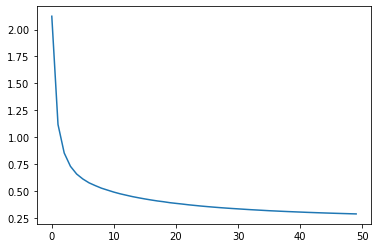

In [25]:
losses = model_detect.train(input_data, output_data, 50)
plt.plot(losses)

In [26]:
is_pos = output_data == 1.

num_true_pos = np.sum(model_detect.predict(input_data)[is_pos])
total_pos = np.sum(is_pos)

is_neg = np.logical_not(is_pos)
num_true_neg = np.sum(1 - model_detect.predict(input_data)[is_neg])
total_neg = np.sum(is_neg)

print(f'Train: True Pos: {num_true_pos}, Total Pos: {total_pos}')
print(f'Train: True Neg: {num_true_neg}, Total Neg: {total_neg}')

Train: True Pos: 209, Total Pos: 247
Train: True Neg: 13736, Total Neg: 15589


## Part 3: Normal Value Prediction Algorithm

In [27]:
model_normal = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])    
    
model_normal.build(input_shape=(None, lag))
model_normal.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=MeanSquaredError()
)

### Build Training Data

In [28]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (15589, 50)
Output Data: datatype: float64, shape: (15589, 1)


In [29]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. , 45. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
    

Epoch 1/20
488/488 [==============================] - 0s 720us/step - loss: 49.6886
Epoch 2/20
488/488 [==============================] - 0s 711us/step - loss: 46.0447
Epoch 3/20
488/488 [==============================] - 0s 691us/step - loss: 44.5824
Epoch 4/20
488/488 [==============================] - 1s 1ms/step - loss: 43.9606
Epoch 5/20
488/488 [==============================] - 0s 719us/step - loss: 43.6401
Epoch 6/20
488/488 [==============================] - 0s 750us/step - loss: 43.5198
Epoch 7/20
488/488 [==============================] - 0s 718us/step - loss: 43.4736
Epoch 8/20
488/488 [==============================] - 0s 782us/step - loss: 43.4576
Epoch 9/20
488/488 [==============================] - 0s 779us/step - loss: 43.4508
Epoch 10/20
488/488 [==============================] - 0s 768us/step - loss: 43.4487
Epoch 11/20
488/488 [==============================] - 0s 791us/step - loss: 43.4479
Epoch 12/20
488/488 [==============================] - 0s 933us/step - loss:

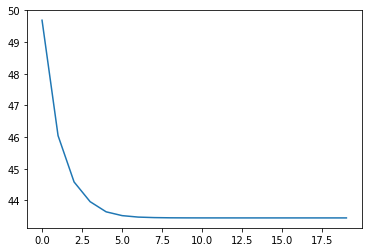

In [30]:
history = model_normal.fit(input_data, output_data, epochs=20)
plt.plot(history.history['loss'])

## Compute Test Loss

In [31]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss: {test_loss_cdf}')

Input Test Data: datatype: float64, shape: (1734, 50)
Output Test Data: datatype: float64, shape: (1734, 1)

Test Loss: 84.87683868408203


# Combining Algorithms

## Forecasting Training Data

In [44]:
input_data = []
output_data = []

for i in range(lag, num_train):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (15836, 50)
Output Test Data: datatype: float64, shape: (15836, 1)



In [45]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]
        
is_extreme = np.squeeze(is_extreme, axis=1)
pred_extreme = np.squeeze(pred_extreme, axis=1)
pred_normal = np.squeeze(pred_normal, axis=1)
pred_outputs = np.squeeze(pred_outputs, axis=1)
output_data = np.squeeze(output_data, axis=1)

In [46]:
print(pred_extreme.shape, output_data.shape)

(15836,) (15836,)


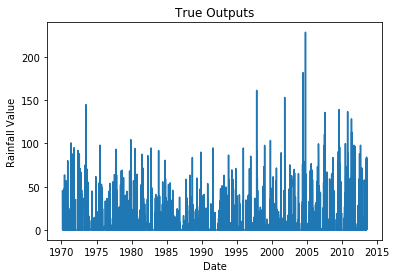

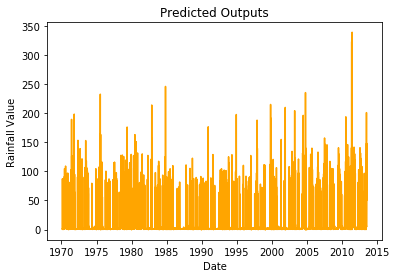

In [47]:
plt.plot(date_series[lag: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[lag: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

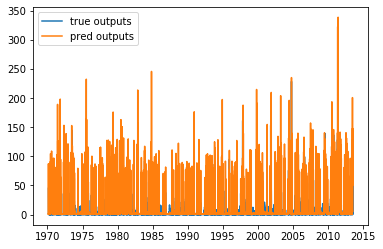

In [48]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

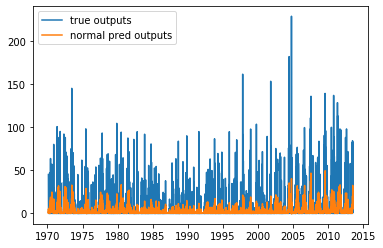

In [49]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

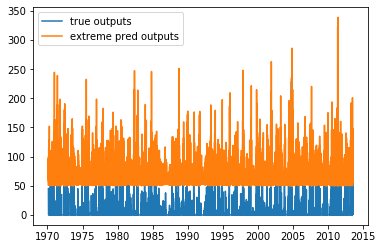

In [50]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()

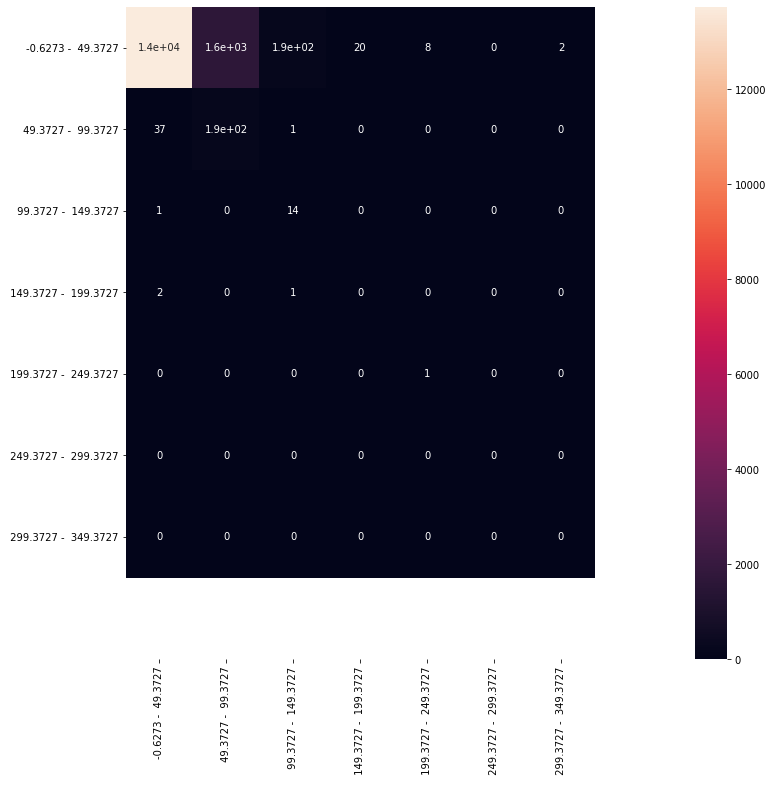

In [51]:
Plot.plotConfusionMatrix(output_data, pred_outputs, 50., 4)

## Forecasting Test Data

In [52]:
input_data = []
output_data = []

for i in range(max(num_train, lag), n):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (1766, 50)
Output Test Data: datatype: float64, shape: (1766, 1)



In [53]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]
        
is_extreme = np.squeeze(is_extreme, axis=1)
pred_extreme = np.squeeze(pred_extreme, axis=1)
pred_normal = np.squeeze(pred_normal, axis=1)
pred_outputs = np.squeeze(pred_outputs, axis=1)
output_data = np.squeeze(output_data, axis=1)

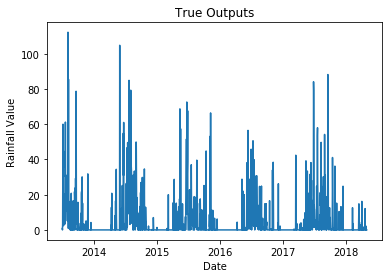

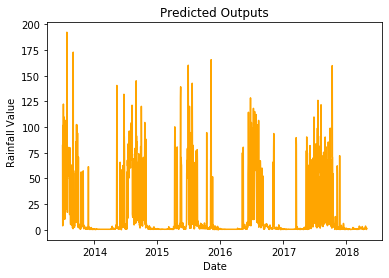

In [54]:
plt.plot(date_series[num_train:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[num_train:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

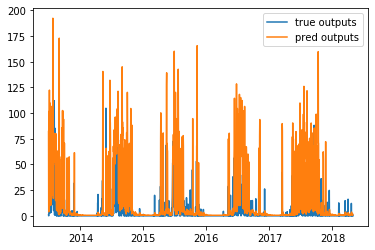

In [55]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

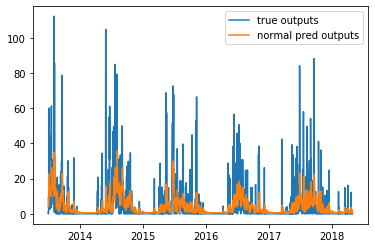

In [56]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

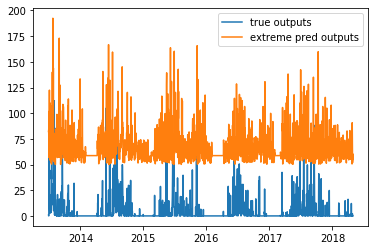

In [57]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()

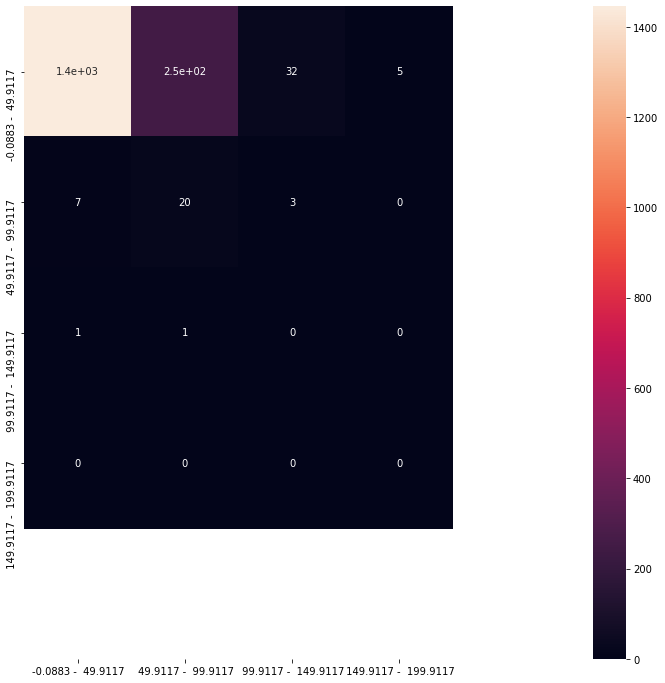

In [58]:
Plot.plotConfusionMatrix(output_data, pred_outputs, 50, 4)

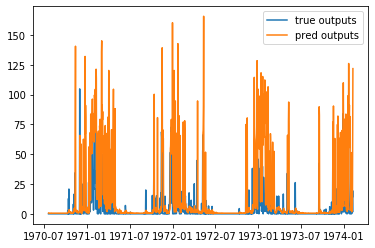

In [60]:
start_idx = 200
end_idx = 1500

plt.plot(date_series[start_idx: end_idx], output_data[start_idx: end_idx], label='true outputs')
plt.plot(date_series[start_idx: end_idx], pred_outputs[start_idx: end_idx], label='pred outputs')
plt.legend()
plt.show()